In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import mmh3 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


(28, 28)


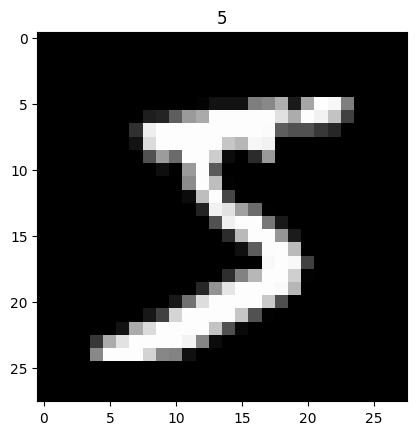

In [3]:
# plot some images
img = x_train[0]
label = y_train[0]
print(img.shape)
plt.imshow(img, cmap='gray')
plt.title(label)
plt.show()

In [4]:
class SimpleEncoder(nn.Module):
    def __init__(self):
        super(SimpleEncoder, self).__init__()
        # A simple CNN encoder: input (batch_size,channels,height,width) -> output vector (batch_size,128)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(32 * 7 * 7, 128)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # output shape: (batch_size, 128)
    
    
encoder = SimpleEncoder()
x = x_train[0]
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
print(x.shape)
emb = encoder(x)
print(emb.shape)


torch.Size([1, 1, 28, 28])
torch.Size([1, 128])


In [5]:
class NeuralBloomFilter(nn.Module):
    def __init__(self, memory_slots=10, word_size=32, class_num=10):
        """
        memory_slots: Number of memory slots (columns in memory matrix)
        word_size: Dimension of the write word and query vector
        """
        super(NeuralBloomFilter, self).__init__()
        self.encoder = SimpleEncoder()
        
        # f_w: maps encoder output to a write word of dimension word_size
        self.fc_w = nn.Linear(128, word_size)
        
        # f_q: maps encoder output to a query vector of dimension word_size
        self.fc_q = nn.Linear(128, word_size)
        
        # Learnable addressing matrix A: shape (word_size, memory_slots)
        self.A = nn.Parameter(torch.randn(word_size, memory_slots), requires_grad=True)
        
        # Memory matrix M: shape (memory_slots, word_size), stored as a buffer (non-trainable)
        self.register_buffer('M', torch.zeros(memory_slots, word_size))

        # MLP for final output: maps read vector to class_num
        self.mlp = nn.Sequential(
            nn.Linear(word_size, 128), # (batch_size, word_size) -> (batch_size, 128)
            nn.ReLU(),
            nn.Linear(128, class_num) # (batch_size, 128) -> (batch_size, class_num)
        )
 
    def write(self, x):
        """
        Write operation: Encode input x, generate write word w and query vector q,
        compute addressing weights a via softmax(q @ A), then update memory: M = M + outer(w, a)
        """
        z = self.encoder(x)         # (batch_size, 128)
        w = self.fc_w(z)            # (batch_size, word_size)
        q = self.fc_q(z)            # (batch_size, word_size)

        a_logits = torch.matmul(q, self.A)  # (batch_size, memory_slots)
        a = F.softmax(a_logits, dim=1)                   # (batch_size, memory_slots)
        
        
        # a -> (batch_size, memory_slots) and w -> (batch_size, word_size)
        # a.unsqueeze(2) -> (batch_size, memory_slots, 1)
        # w.unsqueeze(1) -> (batch_size, 1, word_size)
        update = torch.matmul(a.unsqueeze(2), w.unsqueeze(1))  # (batch_size, memory_slots, word_size)
        
        self.M = self.M + update.sum(dim=0) # (memory_slots, word_size)
        
        return a 

    def read(self, x):
        """
        Read operation: Given input x, generate query vector q, compute addressing weights a, 
        then read from memory via weighted sum: read_vector = a @ M, resulting in a vector of dimension word_size.
        """
        z = self.encoder(x)         # (batch_size, 128)
        q = self.fc_q(z)            # (batch_size, word_size)
        a_logits = torch.matmul(q, self.A)  # (batch_size, memory_slots)
        a = F.softmax(a_logits, dim=1)                   # (batch_size, memory_slots)
        # Read: weighted sum over memory slots:
        read_vector = torch.matmul(a, self.M)       # (batch_size, word_size)
        
        logits = self.mlp(read_vector) # (batch_size, class_num)
        return logits

    def forward(self, x, mode='read'):
        if mode == 'write':
            return self.write(x)
        else:
            return self.read(x)
        
        
# Example usage:
model = NeuralBloomFilter(memory_slots=3, word_size=2, class_num=2)
x = torch.randn(1, 1, 28, 28)

model.write(x)

# Print the memory matrix M after writing
print("Memory matrix M after write:")
print(model.M.shape)

# Read from the memory
logits = model.read(x)
print("Logits after read:")
print(logits.shape)
print(logits)

# Convert logits to probabilities
probs = F.softmax(logits, dim=1)
print("Probabilities:")
print(probs.shape)
print(probs)

# Final class predictions
_, predicted_class = torch.max(probs, 1)
print("Predicted classes:")
print(predicted_class)

Memory matrix M after write:
torch.Size([3, 2])
Logits after read:
torch.Size([1, 2])
tensor([[-0.0581, -0.0974]], grad_fn=<AddmmBackward0>)
Probabilities:
torch.Size([1, 2])
tensor([[0.5098, 0.4902]], grad_fn=<SoftmaxBackward0>)
Predicted classes:
tensor([0])


In [6]:
class BackupBloomFilter:
    def __init__(self, capacity, error_rate):
        """
        capacity: Expected number of elements
        error_rate: Desired false positive rate (e.g., 0.01)
        """
        self.capacity = capacity
        self.error_rate = error_rate
        self.num_bits = self.get_num_bits(capacity, error_rate)
        self.num_hashes = self.get_num_hashes(self.num_bits, capacity)
        # Using a simple Python list for bit array (0 or 1)
        self.bit_array = [0] * self.num_bits

    def add(self, item):
        """
        Adds an item to the Bloom filter by hashing it with num_hashes and setting bits.
        """
        for i in range(self.num_hashes):
            hash_val = mmh3.hash(str(item), i) % self.num_bits 
            self.bit_array[hash_val] = 1

    def __contains__(self, item):
        """
        Returns True if the item is probably in the filter (all corresponding bits are 1),
        or False if the item is definitely not in the filter.
        """
        for i in range(self.num_hashes):
            hash_val = mmh3.hash(str(item), i) % self.num_bits
            if self.bit_array[hash_val] == 0:
                return False
        return True

    @staticmethod
    def get_num_bits(capacity, error_rate):
        """
        Calculates the number of bits (m) needed using: m = - (n * ln(p)) / (ln(2)^2)
        """
        m = - (capacity * math.log(error_rate)) / (math.log(2) ** 2)
        return int(m)

    @staticmethod
    def get_num_hashes(num_bits, capacity):
        """
        Calculates the number of hash functions (k) using: k = (m / n) * ln(2)
        """
        k = (num_bits / capacity) * math.log(2)
        return int(k)
    
# Example usage of BackupBloomFilter
capacity = 10000
error_rate = 0.1
bbf = BackupBloomFilter(capacity, error_rate)
bbf.add("example_item")
print("example_item" in bbf)  # Should return True
print("nonexistent_item" in bbf)  # Should return False
print(bbf.num_bits) # Number of bits in the filter
print(bbf.num_hashes) # Number of hash functions used

True
False
47925
3


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import random


def sample_task(labels, storage_set_size=10, num_queries=20):
    class_to_indices = {}
    for idx, label in enumerate(labels):
        if label not in class_to_indices:
            class_to_indices[label] = []
        class_to_indices[label].append(idx)
    
    chosen_class = random.choice(list(class_to_indices.keys()))
    print(f"Chosen class for storage set: {chosen_class}")
    storage_indices = random.sample(class_to_indices[chosen_class], storage_set_size)

    num_in = num_queries // 2
    num_out = num_queries - num_in
    query_in_indices = random.sample(class_to_indices[chosen_class], num_in)
    other_classes = [c for c in class_to_indices if c != chosen_class]
    query_out_indices = []
    for _ in range(num_out):
        other_class = random.choice(other_classes)
        query_out_indices.append(random.choice(class_to_indices[other_class]))
    
    query_indices = query_in_indices + query_out_indices
    targets = torch.tensor([1] * num_in + [0] * num_out, dtype=torch.long)
    
    return storage_indices, query_indices, targets, class_to_indices, chosen_class

storage_indices, query_indices, targets, class_to_indices, chosen_class = sample_task(y_train, storage_set_size=600, num_queries=100)



Chosen class for storage set: 6


In [10]:
def meta_train(model, dataset, labels, optimizer, criterion, device, meta_epochs=10, storage_set_size=60, num_queries=10):
    model.train()
    total_loss = 0.0
    
    for epoch in range(meta_epochs):
        storage_indices, query_indices, targets, _, _ = sample_task(labels, storage_set_size, num_queries)
        
        # Load images for storage set S and query set Q.
        storage_images = dataset[storage_indices]
        
        query_images = dataset[query_indices]
        targets = targets.to(device)  # shape: (num_queries,)
        
        # Reset model memory for the current task.
        model.M.zero_()
        
        # Write phase: write all images in S into memory.
        # (Assumes your write() method supports batch inputs.)
        _ = model.write(storage_images)  # Expected shape: (storage_set_size, word_size)
        
        # Read phase: obtain logits for all query images.
        logits = model.read(storage_images)  # Expected shape: (num_queries, class_num)
        
        # Compute cross-entropy loss (treating it as a binary classification: in-set vs. not in-set).
        loss = criterion(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if (epoch + 1) % 1 == 0:
            avg_loss = total_loss / (epoch + 1)
            print(f"Meta Epoch [{epoch+1}/{meta_epochs}], Loss: {loss.item():.4f}, Avg Loss: {avg_loss:.4f}")
    
    return total_loss / meta_epochs



In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

if __name__ == '__main__':
    # Hyperparameters
    meta_epochs = 1000  # Number of meta-tasks/episodes
    storage_set_size = 10
    num_queries = 20
    learning_rate = 0.001

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # MNIST dataset and transform
    # Initialize your Neural Bloom Filter model (with desired parameters)
    # Here, for demonstration, we use memory_slots=3, word_size=2, and class_num=2 (binary classification)
    model = NeuralBloomFilter(memory_slots=3, word_size=32, class_num=2).to(device)
    
    # Use CrossEntropyLoss for binary classification (2 classes)
    criterion = nn.CrossEntropyLoss()
    
    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Start meta-training
    avg_loss = meta_train(model, x_train, y_train,optimizer, criterion, device,
                          meta_epochs=meta_epochs,
                          storage_set_size=storage_set_size,
                          num_queries=num_queries)
    print(f"Meta-training completed. Average Loss: {avg_loss:.4f}")

Chosen class for storage set: 2


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
